# Imports

In [22]:
import json
import os

import matplotlib.pyplot as plt
from lingua import LanguageDetectorBuilder
import pandas as pd
import seaborn as sns
from scipy.ndimage import sum_labels
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Data Import and Preparation

In [5]:
domains = []
titles = []
texts = []
publish_dates = []
categories = []
for root, dirs, files in os.walk("../rawdata/webz_io_Dataset"):
    for file in files:
        if file.endswith(".json"):
            file_path = os.path.join(root, file)

            with open(file_path, "r") as f:
                article_data = json.load(f)

                domains.append(article_data.get("thread", pd.NA).get("site", pd.NA))
                titles.append(article_data.get("title", pd.NA))
                texts.append(article_data.get("text", pd.NA))
                publish_dates.append(article_data.get("published", pd.NA))
                categories.append(
                    article_data.get("trust", pd.NA).get("categories", pd.NA)
                )

df = pd.DataFrame(
    {
        "domain": domains,
        "title": titles,
        "text": texts,
        "publish_date": publish_dates,
        "categories": categories,
    }
)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   domain        1000 non-null   object
 1   title         1000 non-null   object
 2   text          1000 non-null   object
 3   publish_date  1000 non-null   object
 4   categories    1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


In [7]:
df = df[df["text"].str.len() > 20]

In [8]:
df["categories"] = df["categories"].apply(lambda x: ", ".join(x))

# Analysis

### Labels

In [9]:
df.groupby("categories").size().sort_values(ascending=False).reset_index(name="n")

,categories,n
0,fake_news,1000


### Most common Domains

In [10]:
df.groupby("domain").size().sort_values(ascending=False).reset_index(name="n")

,domain,n
0,newsbreak.com,386
1,news18.com,67
2,dnr-news.ru,37
3,mehrnews.com,32
4,hindustantimes.com,25
...,...,...
139,ftworthtimes.com,1
140,southsanantonionews.com,1
141,foxnews.com,1
142,swoknews.com,1


### Most Common Languages

In [11]:
detector = LanguageDetectorBuilder.from_all_spoken_languages().build()

df["language"] = df["text"].apply(
    lambda x: detector.detect_language_of(x).iso_code_639_1.name
)

<Axes: xlabel='count', ylabel='language'>

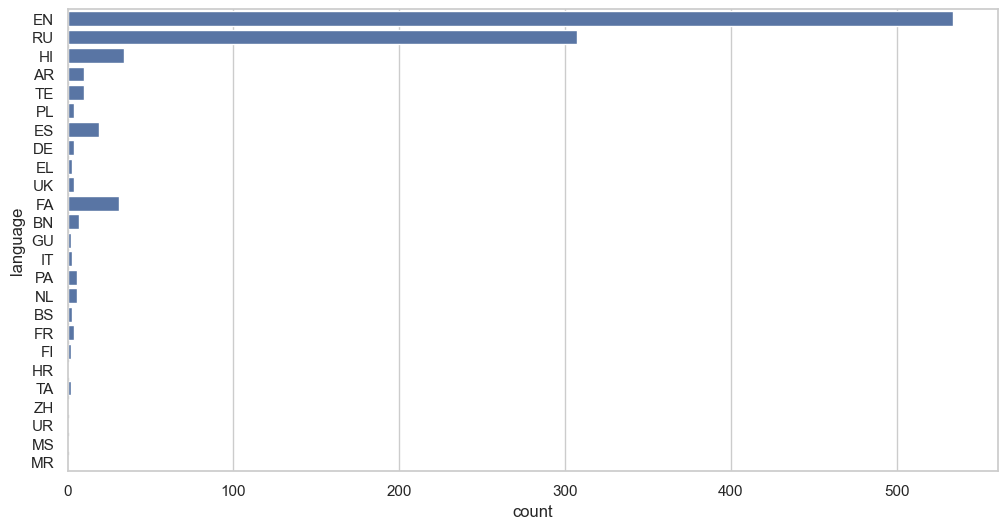

In [12]:
sns.countplot(df["language"])

#### Remove non english articles

In [13]:
df = df[df["language"] == "EN"]

### Ngrams

In [38]:
vec = CountVectorizer(stop_words=list(ENGLISH_STOP_WORDS), ngram_range=(1, 1)).fit(
    df["text"]
)
bag_of_words = vec.transform(df["text"])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

words_freq[:20]

[('said', np.int64(601)),
 ('read', np.int64(474)),
 ('ago', np.int64(392)),
 ('new', np.int64(318)),
 ('news', np.int64(289)),
 ('hours', np.int64(264)),
 ('game', np.int64(262)),
 ('year', np.int64(257)),
 ('school', np.int64(254)),
 ('nov', np.int64(253)),
 ('state', np.int64(252)),
 ('high', np.int64(245)),
 ('2025', np.int64(241)),
 ('article', np.int64(234)),
 ('time', np.int64(226)),
 ('just', np.int64(222)),
 ('people', np.int64(215)),
 ('newsbreak', np.int64(202)),
 ('like', np.int64(201)),
 ('10', np.int64(189))]

### Wordcloud

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

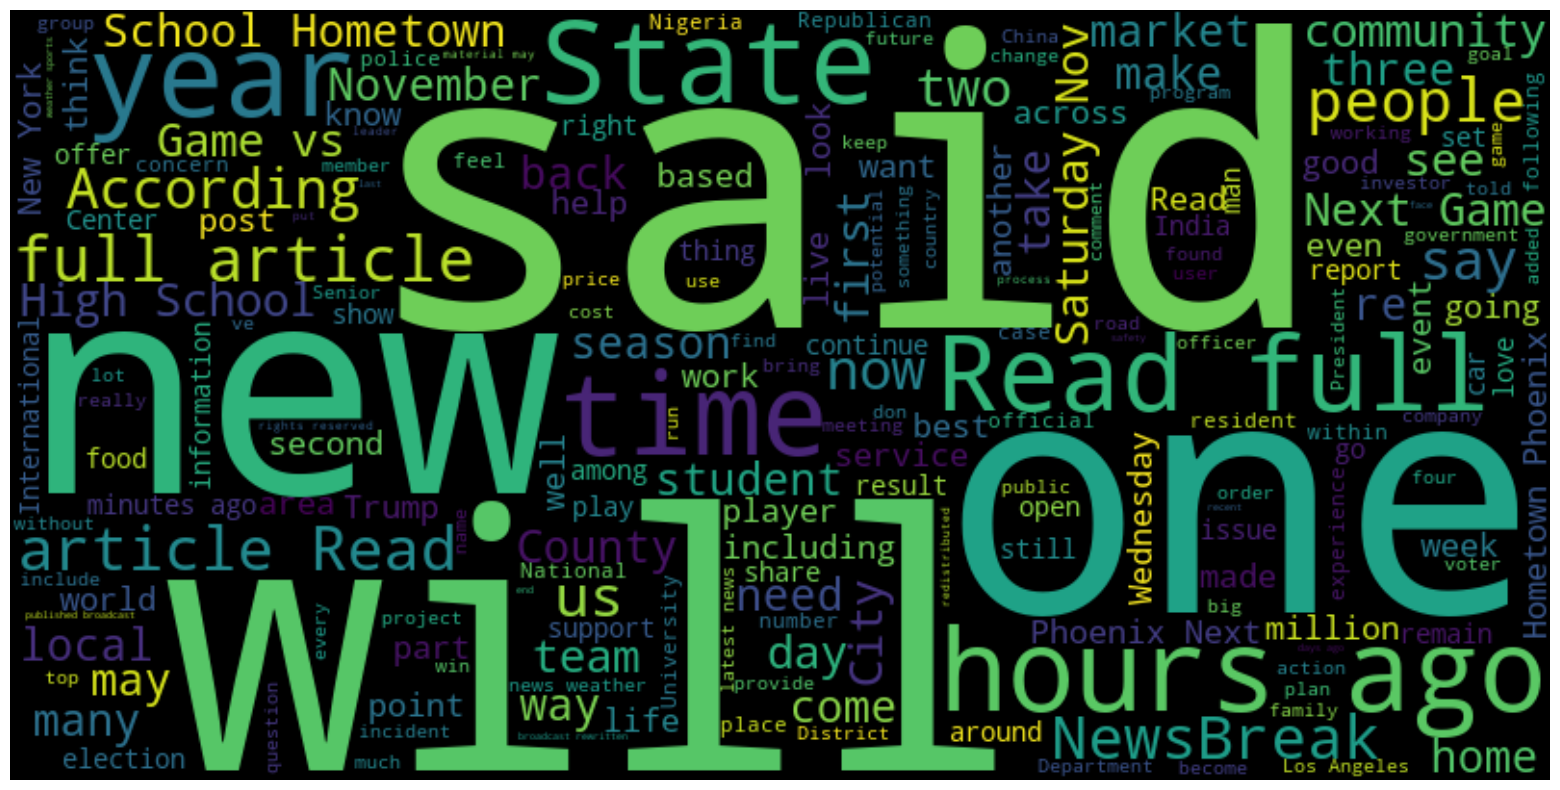

In [45]:
wc = WordCloud(width=800, height=400, min_word_length=2).generate(" ".join(df["text"]))

plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")